In [78]:
import scipy.io
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pickle
import pandas as pd
from scipy.io import loadmat
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
%matplotlib ipympl
%matplotlib inline

In [2]:
data = loadmat("data/Lab8/ex8data1.mat")

In [3]:
X1, X1_val, y1_val = data["X"], data["Xval"], data["yval"]
y1_val = y1_val.reshape(len(y1_val))

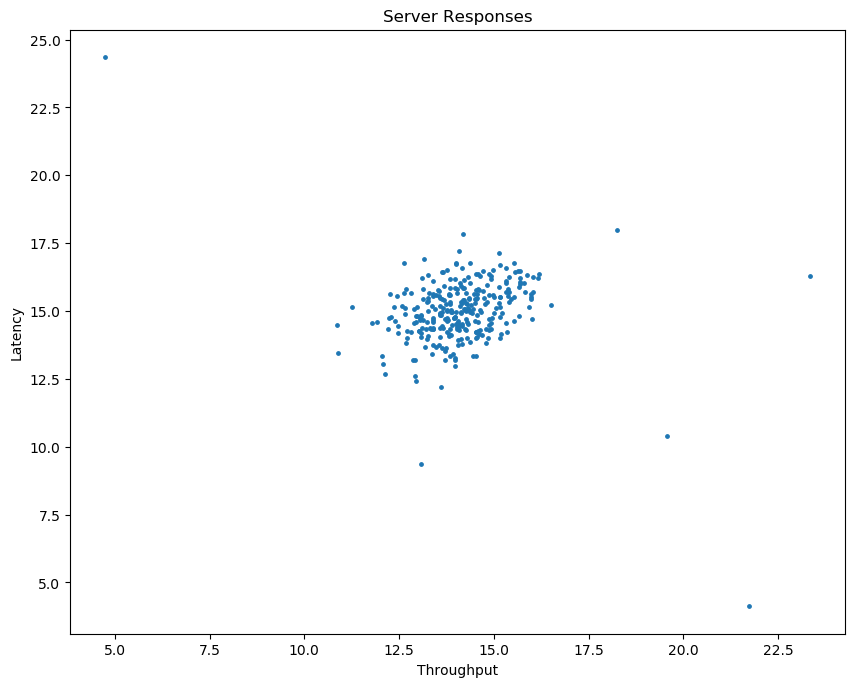

In [4]:
plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.xlabel("Throughput")
plt.ylabel("Latency")
plt.title("Server Responses")
plt.scatter(X1[:, 0], X1[:, 1], s=6)

In [5]:
throughput_values=X1[:, 0]
latency_values=X1[:, 1]
print(f"Throughput mean={np.mean(throughput_values)}")
print(f"Throughput variance={np.var(throughput_values)}")
print(f"Latency mean={np.mean(latency_values)}")
print(f"Latency variance={np.var(latency_values)}")
throghput_variable=scipy.stats.norm(loc=np.mean(throughput_values), scale=np.var(throughput_values))
latency_variable=scipy.stats.norm(loc=np.mean(latency_values), scale=np.var(latency_values))
def get_responses_variable_density(responses):
    def _calculate_densities(x):
        return throghput_variable.pdf(x[0])*latency_variable.pdf(x[1])
    return np.apply_along_axis(_calculate_densities, 1, responses)

Throughput mean=14.112225783945592
Throughput variance=1.8326314134945172
Latency mean=14.99771050813621
Latency variance=1.7097453308287784


(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   9.,  44., 123.,
         96.,  28.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 4.12623222,  5.13744098,  6.14864973,  7.15985848,  8.17106723,
         9.18227598, 10.19348473, 11.20469348, 12.21590223, 13.22711098,
        14.23831974, 15.24952849, 16.26073724, 17.27194599, 18.28315474,
        19.29436349, 20.30557224, 21.31678099, 22.32798975, 23.3391985 ,
        24.35040725]),
 <a list of 20 Patch objects>)

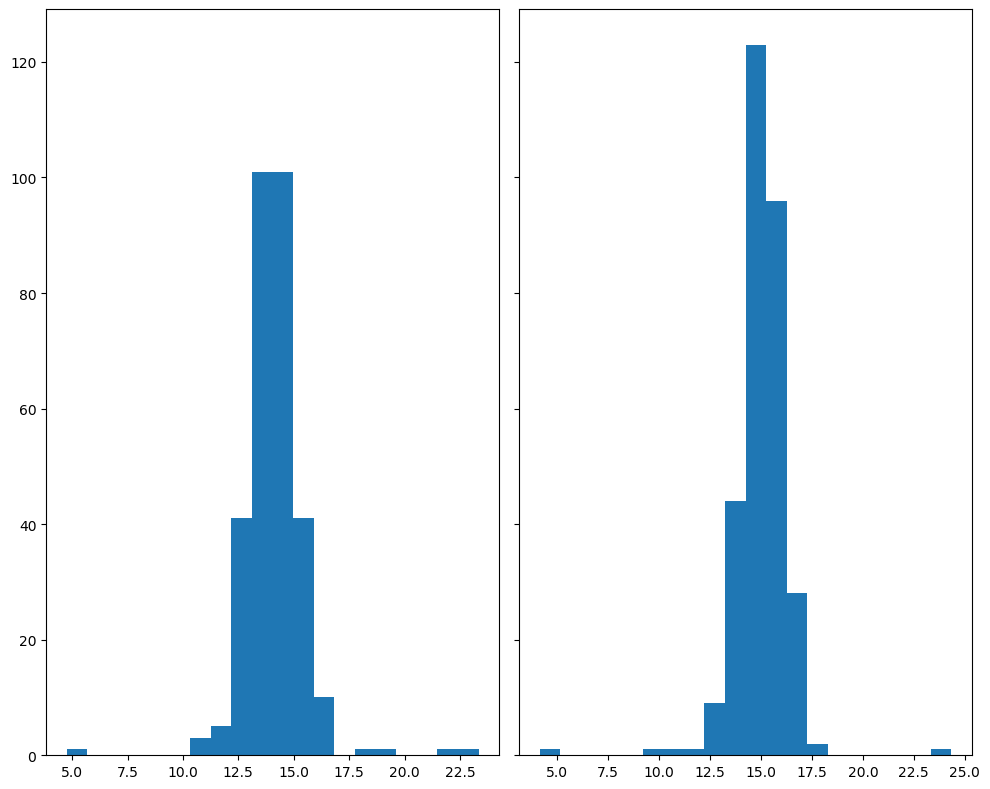

In [6]:
n_bins = 20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10, 8), dpi= 100)
axs[0].hist(throughput_values, bins=n_bins)
axs[1].hist(latency_values, bins=n_bins)

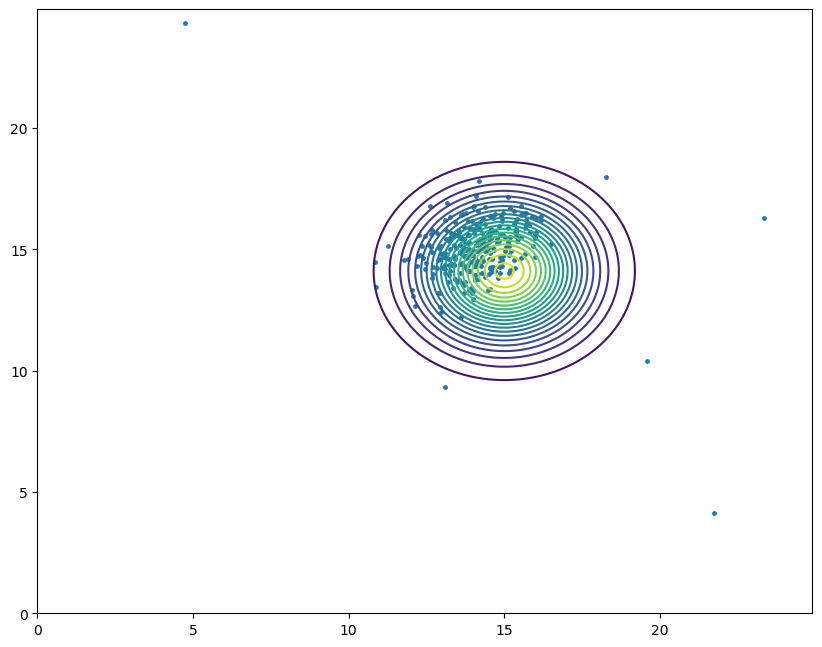

In [7]:
throughput_arr=np.arange(0, 25, .1)
latency_arr=np.arange(0, 25, .1)
n=throughput_arr.shape[0]
responses=np.zeros((n, 2))
density_values=np.zeros((n, n))
for d_idx in range(throughput_arr.shape[0]):
    responses[:, 0]=throughput_arr[d_idx]
    responses[:, 1]=latency_arr[:]
    density_values[d_idx, :]=get_responses_variable_density(responses)
fig, ax = plt.subplots(figsize=(10, 8), dpi= 100)
ax.contour(throughput_arr, latency_arr, density_values, levels=20)
ax.scatter(X1[:, 0], X1[:, 1], s=6)

In [54]:
class ResponseEstimator(BaseEstimator):
    def __init__(self, eps=0.3):
        self.eps=eps
        
    def fit(self, X, y):
        throughput_values=X[:, 0]
        latency_values=X[:, 1]
        self.throghput_variable=scipy.stats.norm(loc=np.mean(throughput_values), scale=np.var(throughput_values))
        self.latency_variable=scipy.stats.norm(loc=np.mean(latency_values), scale=np.var(latency_values))
        
    def get_responses_variable_density(self, responses):
        def _calculate_densities(x):
            return self.throghput_variable.pdf(x[0])*self.latency_variable.pdf(x[1])
        return np.apply_along_axis(_calculate_densities, 1, responses)
    
    def predict(self, X):
        preds=np.zeros(X.shape[0])
        densities=self.get_responses_variable_density(X)
        preds[densities<self.eps]=1
        return preds
    
    def get_params(self, deep=True):
        return {
            "eps":self.eps
        }
    
    def set_params(self, **params):
        self.eps=params["eps"]
        return self

In [55]:
y1_val = y1_val.astype(np.int8)
kf = KFold(n_splits=5)
folds = list(kf.split(X1_val, y1_val))

In [56]:
resp_estimator=ResponseEstimator()
f1sc = make_scorer(f1_score)
ps = {"eps": np.linspace(0.0, 0.1, 100)}
search = GridSearchCV(estimator=resp_estimator, param_grid=ps, scoring=f1sc, cv=folds)
# print(search.best_score_)
search.fit(X1_val, y1_val)

D:\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=[(array([ 62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152...
       0.07575758, 0.07676768, 0.07777778, 0.07878788, 0.07979798,
       0.08080808, 0.08181818, 0.08282828, 0.08383838, 0.08484848,
       0.08585859, 0.08686869, 0.08787879, 0.08888889, 0.08989899,
       0.09090909, 0.09191919, 0.09292929, 0.09393939, 0.09494949,
       0.0959596 , 0.0969697 , 0.0979798 , 0.0989899 , 0.1       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), verbose=0)

In [57]:
df = pd.DataFrame(search.cv_results_)
#df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head(10)

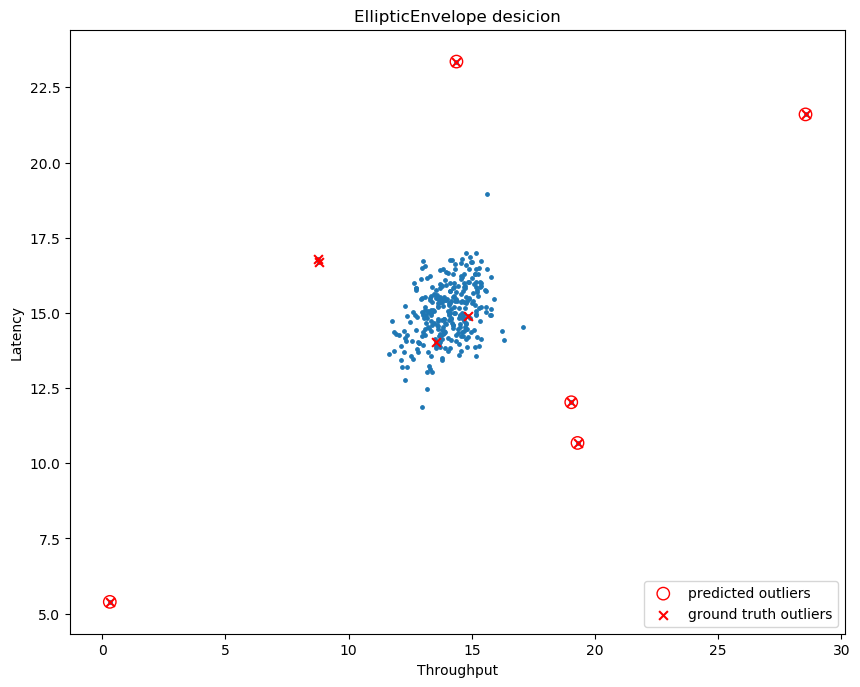

In [58]:
optimal_estimator = search.best_estimator_
pred = optimal_estimator.predict(X1_val)
plt.figure(figsize=(10, 8), dpi= 100)
plt.xlabel("Throughput")
plt.ylabel("Latency")
plt.title("EllipticEnvelope desicion")
plt.scatter(X1_val[:, 0], X1_val[:, 1], s=6)
plt.scatter(X1_val[pred == 1, 0], X1_val[pred == 1, 1],  
           facecolors="none", edgecolors="red", s=80, label="predicted outliers")
plt.scatter(X1_val[y1_val == 1, 0], X1_val[y1_val == 1, 1], marker="x", 
           color="r", s=40, label="ground truth outliers")
plt.legend(loc="lower right")

In [79]:
data = loadmat("data/Lab8/ex8data2.mat")
X2, X2_val, y2_val = data["X"], data["Xval"], data["yval"]

In [80]:
print(f"Mean={np.mean(X2, axis=0)}")
print(f"Variance={np.var(X2, axis=0)}")
print(f"Covarivance={np.cov(X2)}")

Mean=[  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
  10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
   8.47372252]
Variance=[60.97489373 53.20572186 58.51546272 84.20403725 65.26859177 89.57487757
 55.63349911 87.16233783 29.62926829 70.7852052  50.50356719]
Covarivance=[[129.89008843 117.36077253 110.46522318 ...  53.70785898  98.27704285
   43.45793926]
 [117.36077253 243.24897249 135.90527633 ...  75.90309948 166.49869975
   59.96596518]
 [110.46522318 135.90527633 228.28034485 ...  74.60313493 144.99714332
   86.73826151]
 ...
 [ 53.70785898  75.90309948  74.60313493 ...  90.63403236  54.76977364
   52.81004781]
 [ 98.27704285 166.49869975 144.99714332 ...  54.76977364 162.79574116
   62.37542113]
 [ 43.45793926  59.96596518  86.73826151 ...  52.81004781  62.37542113
   68.56084896]]


In [81]:
y2_val = y2_val.astype(np.int8)
y2_val[y2_val==1] = -1
y2_val[y2_val==0] = 1
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(X2_val, y2_val))

In [83]:
class MultivariateEstimator(BaseEstimator):
    def __init__(self, eps=0.3):
        self.eps=eps
        
    def fit(self, X, y):
        self.mv_var=multivariate_normal(mean=np.mean(X, axis=0), cov=np.cov(X.T))
        
    def get_responses_variable_density(self, X):
        return self.mv_var.pdf(X)
    
    def predict(self, X):
        preds=np.zeros(X.shape[0])
        densities=self.get_responses_variable_density(X)
        preds[densities<self.eps]=1
        return preds
    
    def get_params(self, deep=True):
        return {
            "eps":self.eps
        }
    
    def set_params(self, **params):
        self.eps=params["eps"]
        return self

In [84]:
ell = EllipticEnvelope()
f1sc = make_scorer(f1_score)
ps = {"contamination": np.linspace(0.0, 0.2, 30)}
search = GridSearchCV(estimator=ell, param_grid=ps, scoring=f1sc, cv=folds)
search.fit(X2_val, y2_val)

D:\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=[(array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])),
                 (array([ 0,  1,  2,  3,  4,  5,  6,  7...
       0.03448276, 0.04137931, 0.04827586, 0.05517241, 0.06206897,
       0.06896552, 0.07586207, 0.08275862, 0.08965517, 0.09655172,
       0.10344828, 0.11034483, 0.11724138, 0.12413793, 0.13103448,
       0.13793103, 0.14482759, 0.15172414, 0.15862069, 0.16551724,
       0.17241379, 0.17931034, 0.1862069 , 0.19310345, 0.2       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), 

In [85]:
df = pd.DataFrame(search.cv_results_)
df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()

,mean_test_score,std_test_score,params
3,0.973136,0.007515,{'contamination': 0.020689655172413796}
4,0.973136,0.007515,{'contamination': 0.027586206896551727}
5,0.973136,0.007515,{'contamination': 0.03448275862068966}
6,0.973136,0.007515,{'contamination': 0.04137931034482759}
9,0.973136,0.007515,{'contamination': 0.062068965517241385}


In [86]:
optimal_ell = search.best_estimator_
pred = optimal_ell.predict(X2_val)
print(f"Anomalies found {np.sum(pred==-1)}")

Anomalies found 3
